In [7]:
import numpy as np
import pandas as pd

import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import matplotlib.patches as patches
import seaborn as sns

from pylab import rcParams

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error

import eli5
import os
from tqdm import tqdm
import gc
import random    
import math
import psutil
import pickle
import datetime

from scipy.interpolate import CubicSpline     
from transforms3d.axangles import axangle2mat




/Users/kirillvladimirov/PycharmProjects/cv_projects/venv/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


In [8]:
warnings.filterwarnings('ignore')

root = "../../data/raw/Gamma_Log_Facies_Type_Prediction/"
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.style.use('seaborn')
pd.set_option('max_columns', 150)
# rcParams['figure.figsize'] = 16,8



In [9]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.


def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [10]:
%%time
train_df = pd.read_csv(root + "Train_File.csv")
test_df = pd.read_csv(root + "Test_File.csv")
submit_df = pd.read_csv(root + "Submission_File.csv")

CPU times: user 3.5 s, sys: 994 ms, total: 4.49 s
Wall time: 4.98 s


In [30]:
%time
reduce_mem_usage(train_df, use_float16=True);
reduce_mem_usage(test_df, use_float16=True);

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs
Memory usage of dataframe is 134.28 MB
Memory usage after optimization is: 29.37 MB
Decreased by 78.1%
Memory usage of dataframe is 67.14 MB
Memory usage after optimization is: 117.77 MB
Decreased by -75.4%


In [31]:
train_df.head()

,row_id,well_id,GR,label
0,0,0,143.5000,0
1,1,0,112.8125,0
2,2,0,123.5625,0
3,3,0,111.6875,0
4,4,0,123.6250,0


In [32]:
test_df.head()

,unique_id,row_id,well_id,GR
0,CAX_0,0,5000,113.9375
1,CAX_1,1,5000,120.8750
2,CAX_2,2,5000,115.3125
3,CAX_3,3,5000,118.8750
4,CAX_4,4,5000,127.7500


In [33]:
train_df.shape, test_df.shape

((4400000, 4), (2200000, 4))

<BarContainer object of 5 artists>

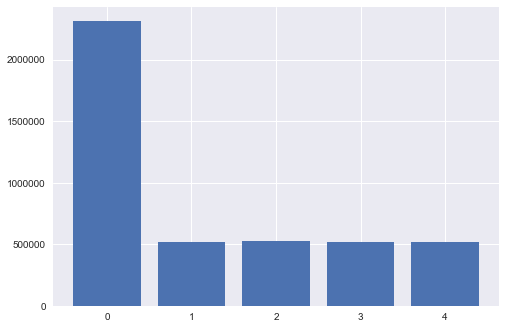

In [34]:
# Количество классов для предсказания

g = train_df["label"].value_counts()
g = g.sort_index().T
plt.bar(g.index, g.values)

<BarContainer object of 1100 artists>

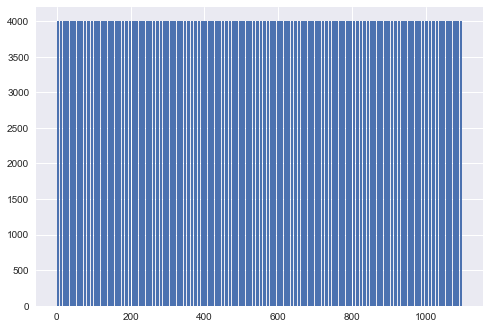

In [8]:
g = train_df["row_id"].value_counts()
g = g.sort_index().T
plt.bar(g.index, g.values)

<BarContainer object of 1100 artists>

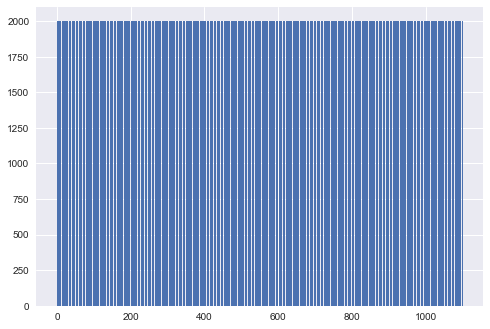

In [9]:
g = test_df["row_id"].value_counts()
g = g.sort_index().T
plt.bar(g.index, g.values)

<BarContainer object of 4000 artists>

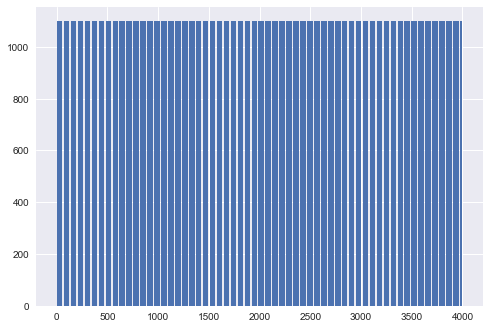

In [10]:
g = train_df["well_id"].value_counts()
g = g.sort_index().T
plt.bar(g.index, g.values)

<BarContainer object of 2000 artists>

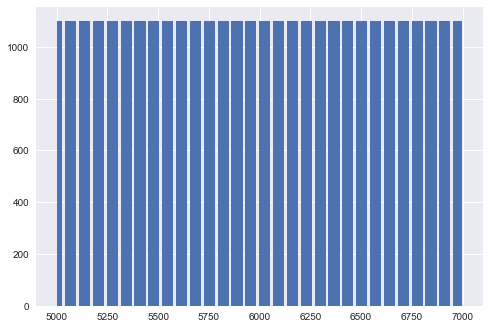

In [11]:
g = test_df["well_id"].value_counts()
g = g.sort_index().T
plt.bar(g.index, g.values)

In [12]:
np.min(train_df["GR"]), np.min(test_df["GR"]), np.max(train_df["GR"]), np.max(test_df["GR"])

(-3.1819153274835728, -4.928221443978856, 197.0614194722475, 196.1690263876252)

In [13]:
def show_meters(well_id):
    temp_df = train_df[train_df["well_id"]==well_id].reset_index(drop=True)

    fig, axs = plt.subplots(2, 1)
    for i in range(4):
        tdf = temp_df[temp_df["meter"]==i]
        axs[i].scatter(x=tdf["timestamp"][::-1], y=tdf["meter_reading"][::-1])
        axs[i].set_title(subtitles[i])
        axs[i].grid(True)
    fig.tight_layout()
    plt.show()

In [14]:
well_id = 0
temp_df = train_df[train_df["well_id"]==well_id].reset_index(drop=True)
temp_df.shape

(1100, 4)

In [35]:
def show_scatter_layers(well_id):
    temp_df = train_df[train_df["well_id"]==well_id].reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(20, 7))
    plt.scatter(x=temp_df["row_id"][::-1], y=temp_df["GR"][::-1], c=temp_df["label"], cmap='viridis', marker='o')
    plt.title(f"Plot for well {well_id}")
    plt.grid(True)
    plt.show()

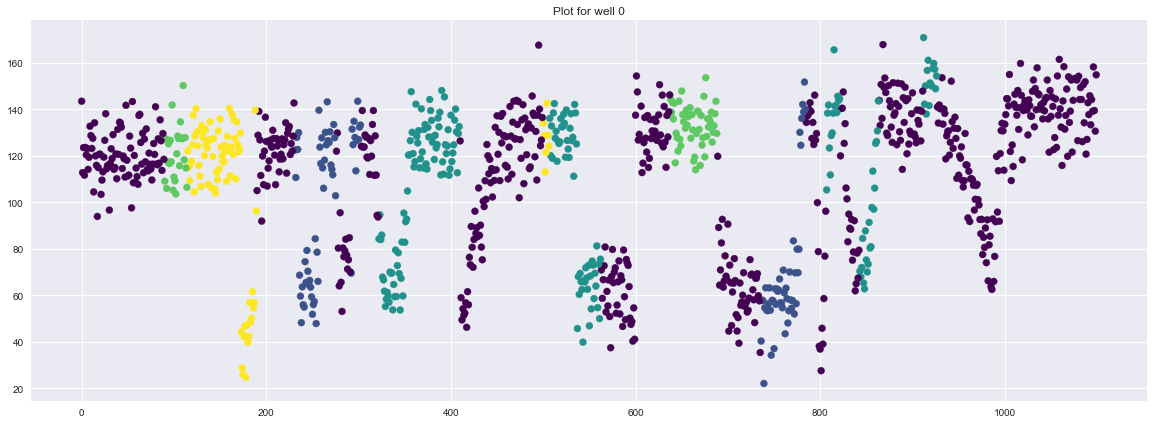

In [36]:
show_scatter_layers(0)

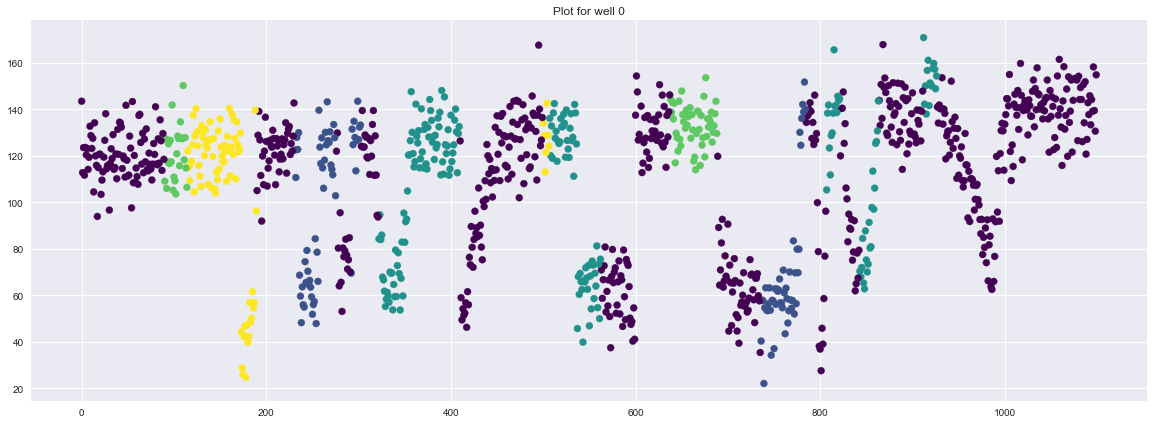

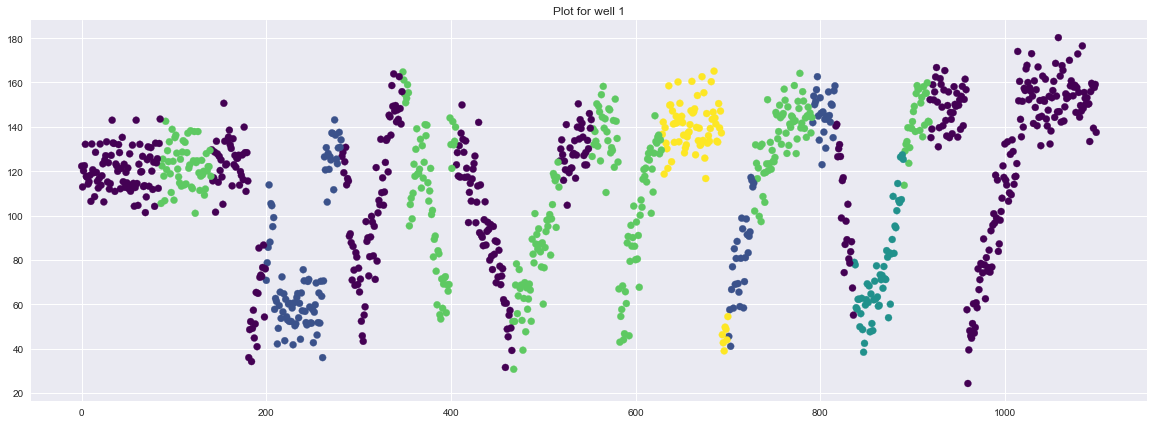

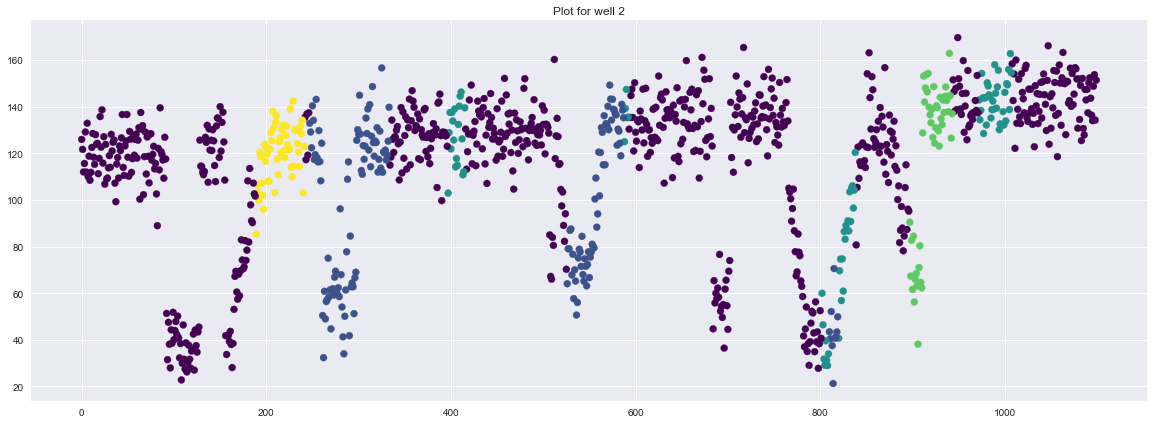

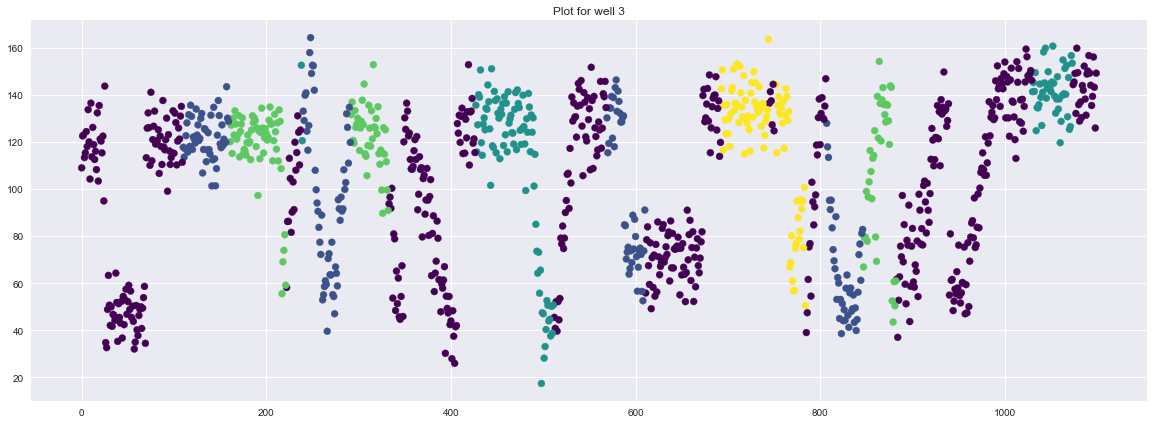

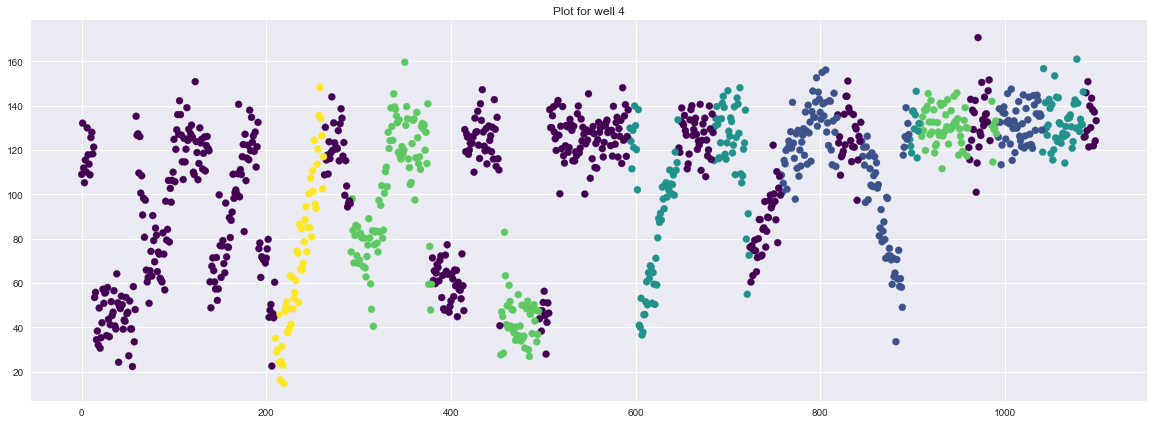

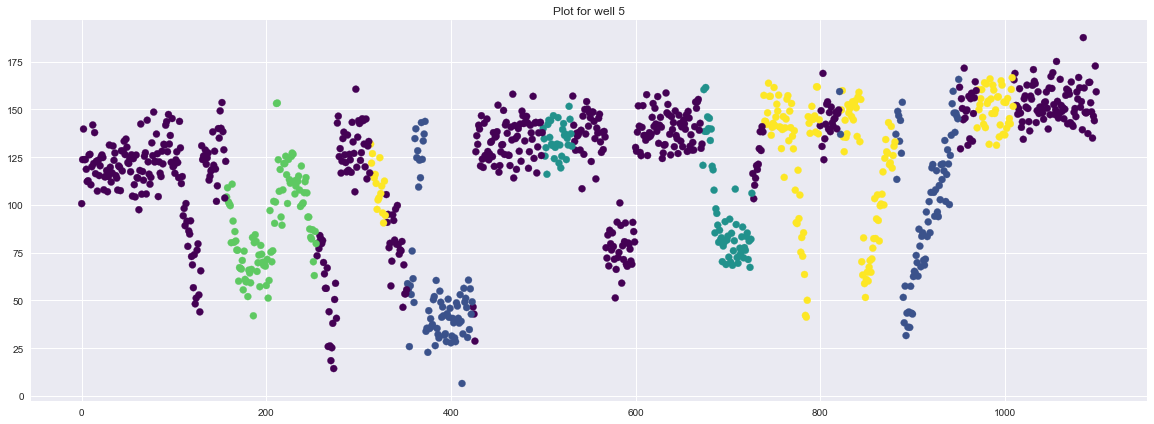

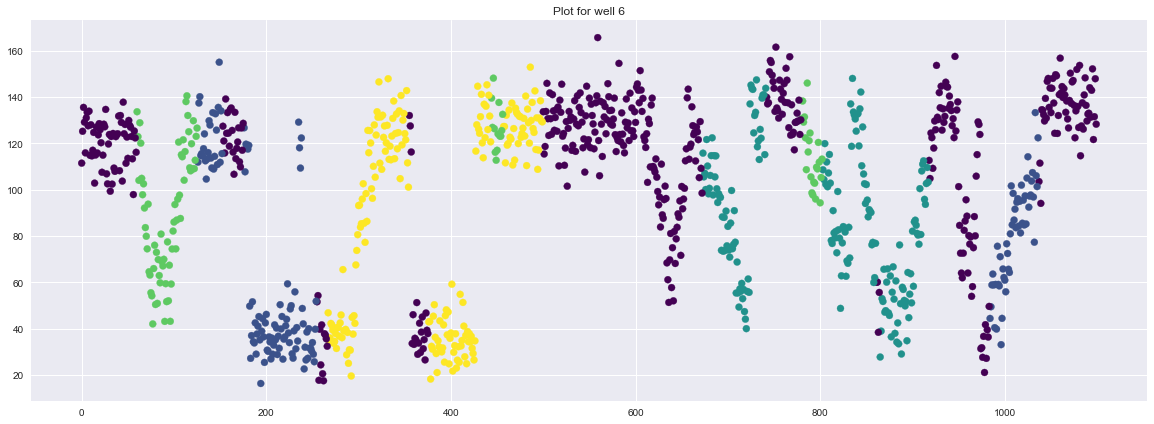

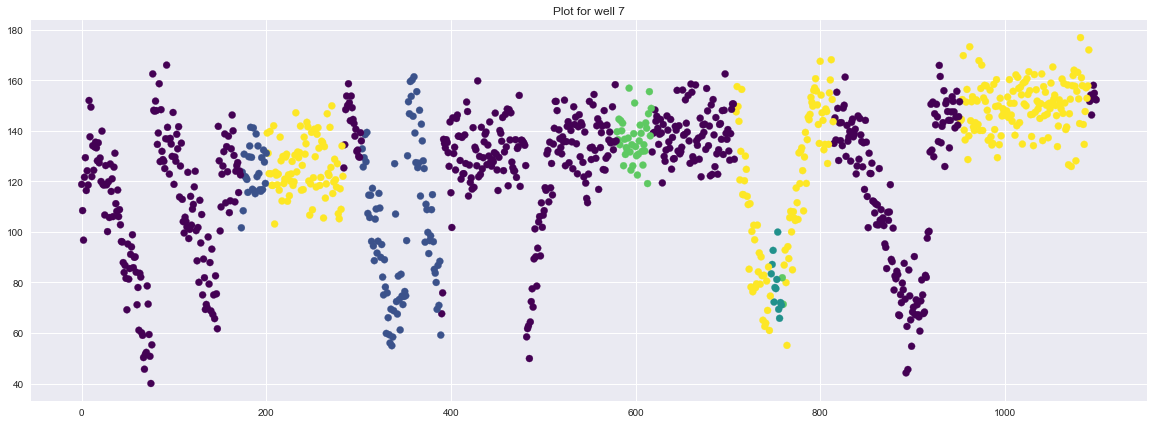

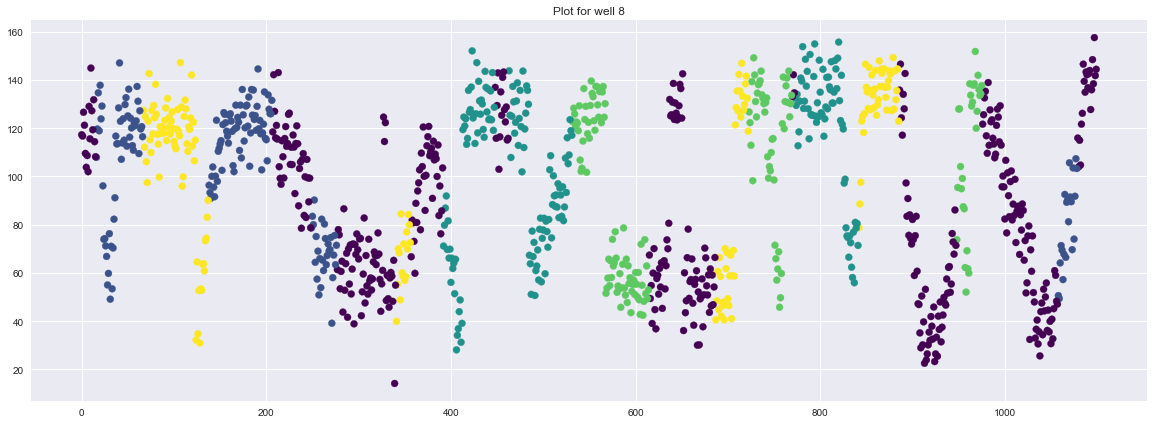

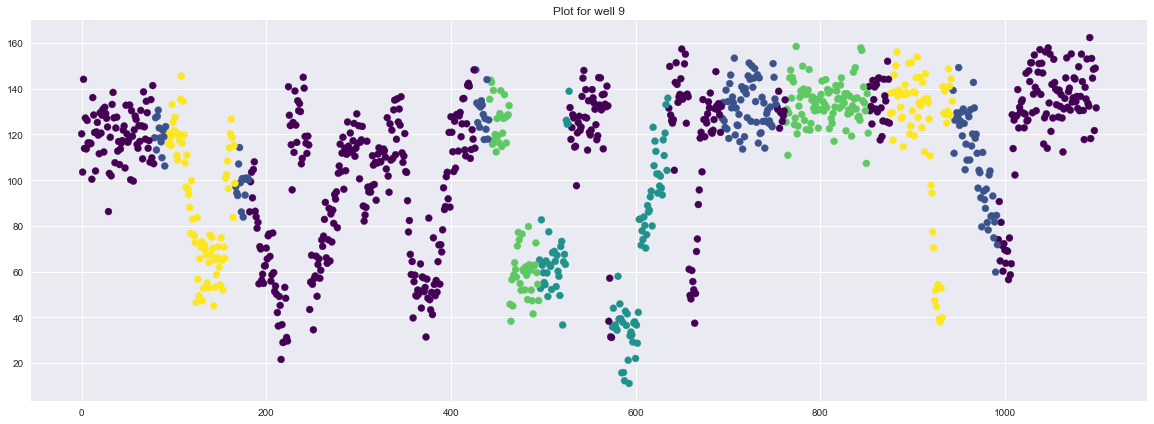

In [37]:
for i in range(10):
    show_scatter_layers(i)

In [38]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

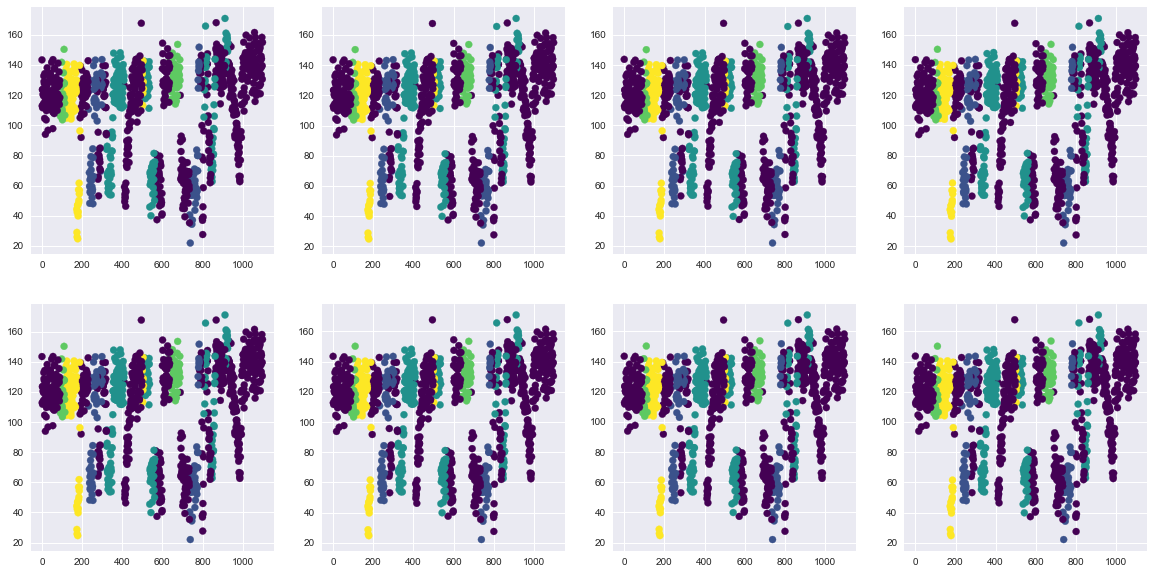

In [73]:
well_id = 0
sigma = 0.1

temp_df = train_df[train_df["well_id"]==well_id].reset_index(drop=True)
fig = plt.figure(figsize=(20,10))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.scatter(x=temp_df["row_id"][::-1], y=DA_Jitter(temp_df["GR"][::-1], sigma), c=temp_df["label"], cmap='viridis', marker='o')

In [45]:
def DA_Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

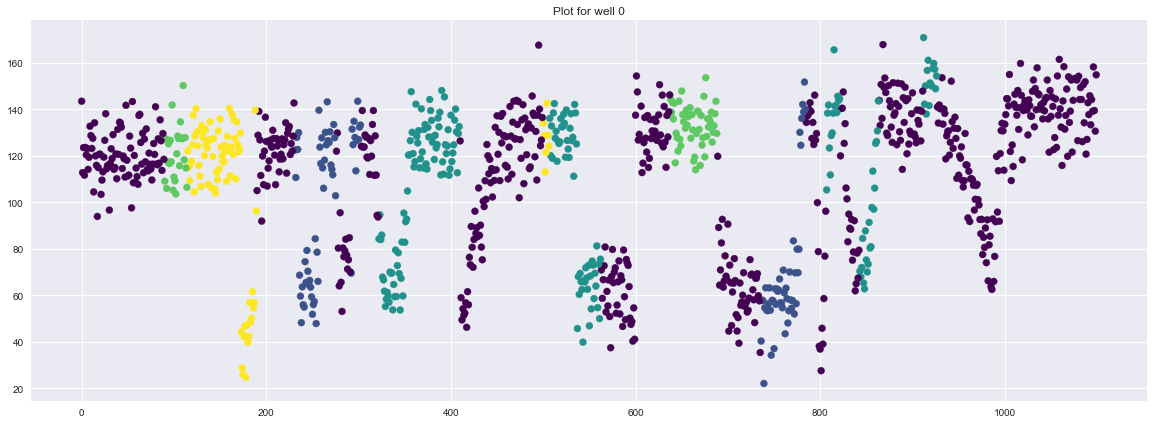

In [50]:
well_id = 0

temp_df = train_df[train_df["well_id"]==well_id].reset_index(drop=True)
fig, ax = plt.subplots(figsize=(20, 7))
plt.scatter(x=temp_df["row_id"][::-1], y=temp_df["GR"][::-1], c=temp_df["label"], cmap='viridis', marker='o')
plt.title(f"Plot for well {well_id}")
plt.grid(True)
plt.show()

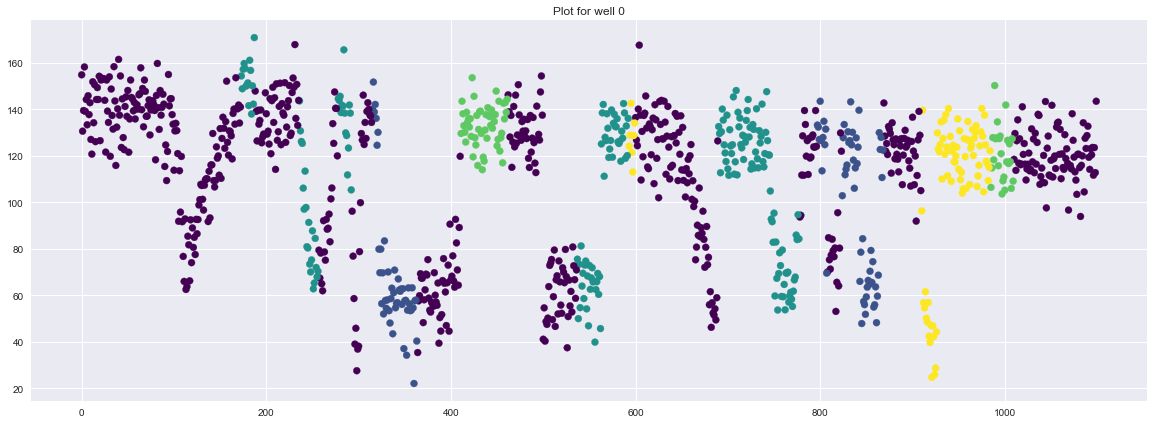

In [53]:
well_id = 0

temp_df = train_df[train_df["well_id"]==well_id].reset_index(drop=True)
x = temp_df["row_id"][::-1]
y = temp_df["GR"][::-1]
c = temp_df["label"]
fig, ax = plt.subplots(figsize=(20, 7))
plt.scatter(x=x, y=y.iloc[::-1], c=c.iloc[::-1], cmap='viridis', marker='o')
plt.title(f"Plot for well {well_id}")
plt.grid(True)
plt.show()

In [75]:
%%time
full_train_df = pd.read_csv(root + "Train_File.csv")
full_test_df = pd.read_csv(root + "Test_File.csv")
submit_df = pd.read_csv(root + "Submission_File.csv")

CPU times: user 2.93 s, sys: 672 ms, total: 3.6 s
Wall time: 3.73 s


In [76]:
train = np.array([x.values[:,2:3].T for group, x in full_train_df.groupby('well_id')], dtype='float32')
target = np.array([x.values[:,3:].T for group, x in full_train_df.groupby('well_id')], dtype='float32')
test = np.array([x.values[:,3:4].T for group, x in full_test_df.groupby('well_id')], dtype='float32')

In [77]:
train.shape, target.shape, test.shape

((4000, 1, 1100), (4000, 1, 1100), (2000, 1, 1100))

In [ ]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

In [79]:
b = np.concatenate((train, test), axis=0)

In [80]:
b.shape

(6000, 1, 1100)

In [81]:
b = DA_Jitter(train)

In [82]:
b.shape

(4000, 1, 1100)

In [83]:
train[0]

array([[143.51   , 112.79093, 123.53185, ..., 139.50815, 130.58907,
        154.93   ]], dtype=float32)

In [84]:
b[0]

array([[143.4888627 , 112.77207218, 123.49662728, ..., 139.49464569,
        130.53250362, 154.96955976]])

In [85]:
b = np.concatenate((train, b), axis=0)

In [86]:
b.shape

(8000, 1, 1100)

In [89]:
b = np.flip(train,2)

In [90]:
b[0]

array([[154.93   , 130.58907, 139.50815, ..., 123.53185, 112.79093,
        143.51   ]], dtype=float32)

In [97]:
np.arange(train[0].shape[1])

array([   0,    1,    2, ..., 1097, 1098, 1099])

In [115]:
train.size

4400000

In [109]:
def DA_Reverce(X):
    return np.flip(X, len(X.shape) - 1)

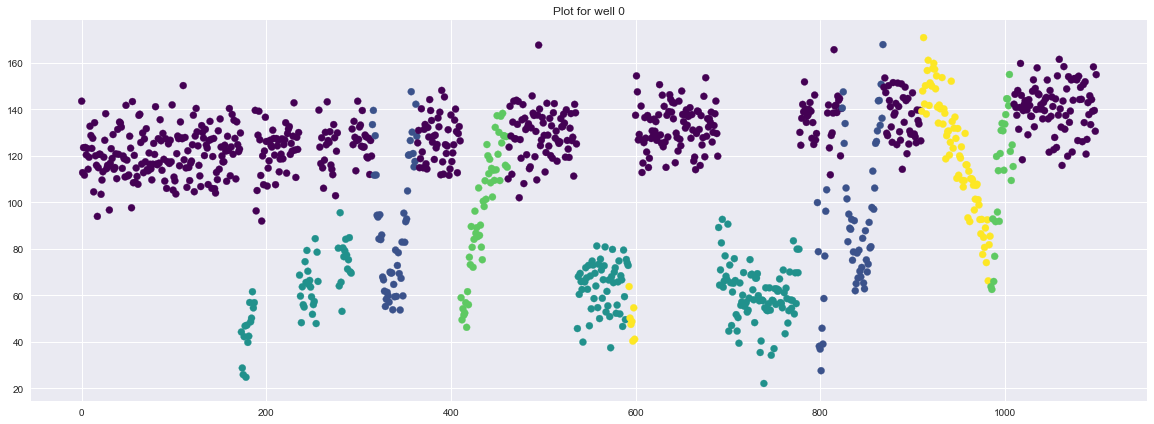

In [107]:
fig, ax = plt.subplots(figsize=(20, 7))
plt.scatter(x=np.arange(train[0].shape[1]), y=train[0], c=target[0], cmap='viridis', marker='o')
plt.title(f"Plot for well {well_id}")
plt.grid(True)
plt.show()

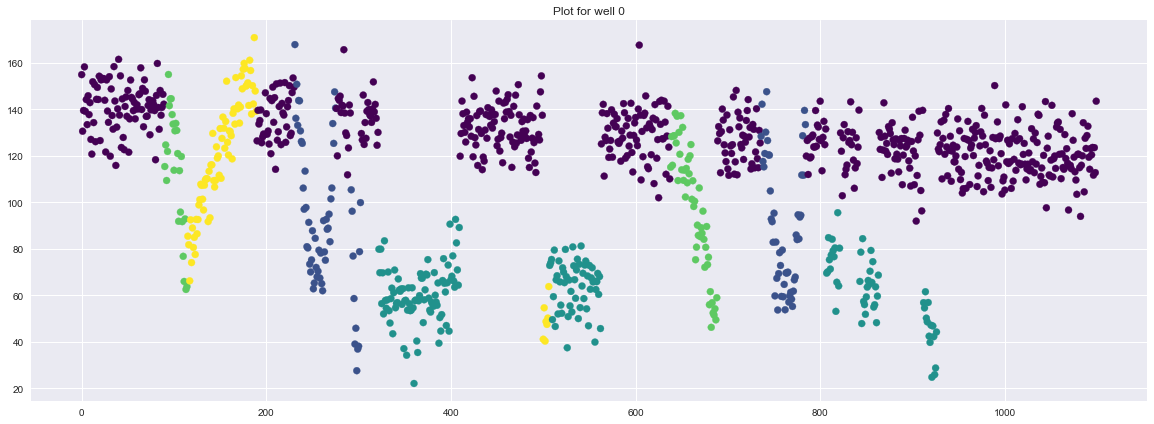

In [110]:
fig, ax = plt.subplots(figsize=(20, 7))
plt.scatter(x=np.arange(train[0].shape[1]), y=DA_Reverce(train[0]), c=DA_Reverce(target[0]), cmap='viridis', marker='o')
plt.title(f"Plot for well {well_id}")
plt.grid(True)
plt.show()

In [ ]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

In [112]:
train[0]

array([[143.51   , 112.79093, 123.53185, ..., 139.50815, 130.58907,
        154.93   ]], dtype=float32)

In [113]:
b = DA_Jitter(train)

In [114]:
b[0]

array([[143.48781597, 112.82424114, 123.58478868, ..., 139.52603086,
        130.6283419 , 154.8743408 ]])

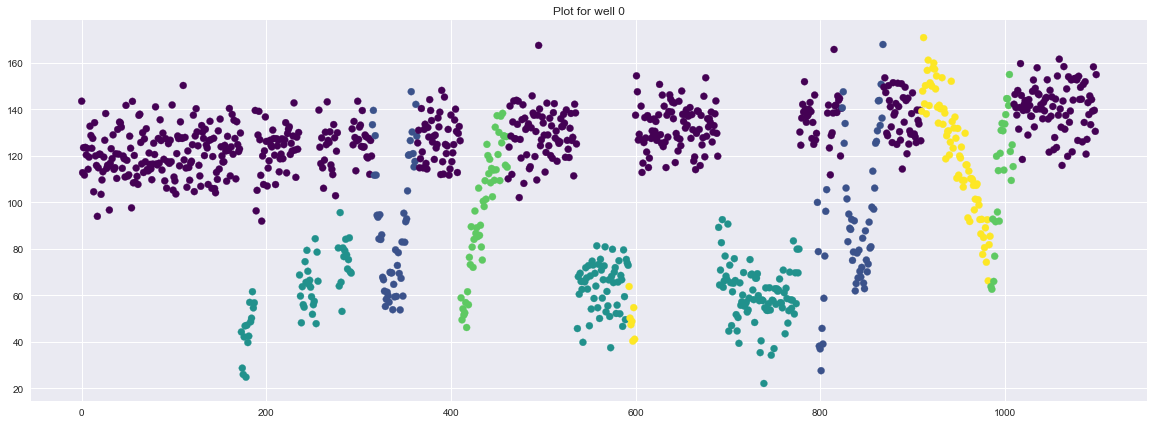

In [101]:
fig, ax = plt.subplots(figsize=(20, 7))
plt.scatter(x=np.arange(train[0].shape[1]), y=DA_Jitter(train[0]), c=target[0], cmap='viridis', marker='o')
plt.title(f"Plot for well {well_id}")
plt.grid(True)
plt.show()

In [1]:
import numpy as np
import pandas as pd
from numpy import newaxis
from sklearn.preprocessing import StandardScaler
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype
from sklearn.model_selection import train_test_split
import gc

root = "../../data/raw/Gamma_Log_Facies_Type_Prediction/"
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise


def DA_Reverse(X):
    return np.flip(X, len(X.shape) - 1)


def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)


def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
%%time
full_train_df = pd.read_csv(root + "Train_File.csv")
full_test_df = pd.read_csv(root + "Test_File.csv")
submit_df = pd.read_csv(root + "Submission_File.csv")

reduce_mem_usage(full_train_df, use_float16=True);
reduce_mem_usage(full_test_df, use_float16=True);

scaler = StandardScaler()
full_train_df[["GR"]] = scaler.fit_transform(full_train_df[["GR"]])
full_test_df[["GR"]] = scaler.transform(full_test_df[["GR"]])

data_array = np.array([x.values[:,2:3].T for group, x in full_train_df.groupby('well_id')], dtype='float32')
target_array = np.array([x.values[:,3:].T for group, x in full_train_df.groupby('well_id')], dtype='float32')
test_data_array = np.array([x.values[:,3:4].T for group, x in full_test_df.groupby('well_id')], dtype='float32')

train_data_array, valid_data_array, train_target_array, valid_target_array = train_test_split(data_array, target_array, test_size=0.33, random_state=RANDOM_STATE)

del full_train_df, full_test_df

reverse_train_data_array = DA_Reverse(train_data_array)
reverse_train_target_array = DA_Reverse(train_target_array)

train_data = train_data_array
train_target = train_target_array
for i in range(3):
    train_data = np.concatenate((train_data, DA_Jitter(train_data_array, sigma=0.2)), axis=0)
    train_target = np.concatenate((train_target, train_target_array), axis=0)

for i in range(3):
    train_data = np.concatenate((train_data, DA_Jitter(reverse_train_data_array, sigma=0.2)), axis=0)
    train_target = np.concatenate((train_target, reverse_train_target_array), axis=0)
    
    
reverse_valid_data_array = DA_Reverse(valid_data_array)
reverse_valid_target_array = DA_Reverse(valid_target_array)

valid_data = valid_data_array
valid_target = valid_target_array
for i in range(3):
    valid_data = np.concatenate((valid_data, DA_Jitter(valid_data_array, sigma=0.1)), axis=0)
    valid_target = np.concatenate((valid_target, valid_target_array), axis=0)

for i in range(3):
    valid_data = np.concatenate((valid_data, DA_Jitter(reverse_valid_data_array, sigma=0.1)), axis=0)
    valid_target = np.concatenate((valid_target, reverse_valid_target_array), axis=0)
    
    
train_data = train_data.reshape(train_data.shape[0], train_data.shape[2])
train_target = train_target.reshape(train_target.shape[0], train_target.shape[2])

valid_data = valid_data.reshape(valid_data.shape[0], valid_data.shape[2])
valid_target = valid_target.reshape(valid_target.shape[0], valid_target.shape[2])

test_data = test_data_array.reshape(test_data_array.shape[0], test_data_array.shape[2])

train_target = train_target.astype(int)
train_target_cat = to_categorical(train_target, 5)

valid_target = valid_target.astype(int)
valid_target_cat = to_categorical(valid_target, 5)

train_data = train_data[:, :, newaxis]
valid_data = valid_data[:, :, newaxis]
test_data = test_data[:, :, newaxis]

del reverse_train_data_array, reverse_train_target_array, train_target, valid_target
gc.collect()

Memory usage of dataframe is 134.28 MB
Memory usage after optimization is: 29.37 MB
Decreased by 78.1%
Memory usage of dataframe is 67.14 MB
Memory usage after optimization is: 117.77 MB
Decreased by -75.4%
CPU times: user 1min 7s, sys: 5.76 s, total: 1min 13s
Wall time: 1min 14s


0

In [6]:
train_data.shape, train_target_cat.shape, valid_data.shape, valid_target_cat.shape, test_data.shape

((18760, 1100, 1),
 (18760, 1100, 5),
 (9240, 1100, 1),
 (9240, 1100, 5),
 (2000, 1100, 1))

In [23]:
%%time
full_train_df = pd.read_csv(root + "Train_File.csv")
full_test_df = pd.read_csv(root + "Test_File.csv")
submit_df = pd.read_csv(root + "Submission_File.csv")

# reduce_mem_usage(full_train_df, use_float16=True);
# reduce_mem_usage(full_test_df, use_float16=True);

# scaler = StandardScaler()
# full_train_df[["GR"]] = scaler.fit_transform(full_train_df[["GR"]])
# full_test_df[["GR"]] = scaler.transform(full_test_df[["GR"]])

# data_array = np.array([x.values[:,2:3].T for group, x in full_train_df.groupby('well_id')], dtype='float32')
# target_array = np.array([x.values[:,3:].T for group, x in full_train_df.groupby('well_id')], dtype='float32')
# test_data_array = np.array([x.values[:,3:4].T for group, x in full_test_df.groupby('well_id')], dtype='float32')

# train_data_array, valid_data_array, train_target_array, valid_target_array = train_test_split(data_array, target_array, test_size=0.33, random_state=RANDOM_STATE)


CPU times: user 3.12 s, sys: 653 ms, total: 3.77 s
Wall time: 3.88 s


In [ ]:
def create_lags(df):
    for i in range(0, 25):
        df["lag_forward_{}".format(i)] = df.GR.shift(i)
        df["lag_backward_{}".format(i)] = df.GR.shift(-i)
    return df

In [24]:
full_train_df.head()

,row_id,well_id,GR,label
0,0,0,143.510000,0
1,1,0,112.790928,0
2,2,0,123.531856,0
3,3,0,111.692784,0
4,4,0,123.613712,0


In [37]:
df = full_train_df.copy()

In [26]:
for i in range(1, 10):
    df["lag_forward_{}".format(i)] = df.GR.shift(i)

In [27]:
df.head()

,row_id,well_id,GR,label,lag_forward_1,lag_forward_2,lag_forward_3,lag_forward_4,lag_forward_5,lag_forward_6,lag_forward_7,lag_forward_8,lag_forward_9
0,0,0,143.510000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,112.790928,0,143.510000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,123.531856,0,112.790928,143.510000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,111.692784,0,123.531856,112.790928,143.510000,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,123.613712,0,111.692784,123.531856,112.790928,143.51,NaN,NaN,NaN,NaN,NaN


In [100]:
df = full_train_df.copy()

In [101]:
def create_lags_backward(df):
    for i in range(1, 10):
        df[f"-{i}"] = df.GR.shift(i)
    return df

def create_lags_forward(df):
    for i in range(1, 10):
        df[f"{i}"] = df.GR.shift(-i)
    return df

In [102]:
df = df[train_df["well_id"] < 100]

df = df.groupby("well_id").apply(create_lags_backward)
# df.reset_index()
df = df.groupby("well_id").apply(create_lags_forward)
df.rename(columns={'GR':'0'}, inplace=True)
df = df.fillna(0)

In [103]:
df.head()

,row_id,well_id,0,label,-1,-2,-3,-4,-5,-6,-7,-8,-9,1,2,3,4,5,6,7,8,9
0,0,0,143.510000,0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,112.790928,123.531856,111.692784,123.613712,120.414641,123.145569,114.216497,119.387425,132.728353
1,1,0,112.790928,0,143.510000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,123.531856,111.692784,123.613712,120.414641,123.145569,114.216497,119.387425,132.728353,128.739281
2,2,0,123.531856,0,112.790928,143.510000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,111.692784,123.613712,120.414641,123.145569,114.216497,119.387425,132.728353,128.739281,123.180209
3,3,0,111.692784,0,123.531856,112.790928,143.510000,0.00,0.0,0.0,0.0,0.0,0.0,123.613712,120.414641,123.145569,114.216497,119.387425,132.728353,128.739281,123.180209,127.551137
4,4,0,123.613712,0,111.692784,123.531856,112.790928,143.51,0.0,0.0,0.0,0.0,0.0,120.414641,123.145569,114.216497,119.387425,132.728353,128.739281,123.180209,127.551137,104.502066


In [114]:
list(range(-9, 10))

[-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [116]:
[str(i) for i in range(-9, 10)]

['-9',
 '-8',
 '-7',
 '-6',
 '-5',
 '-4',
 '-3',
 '-2',
 '-1',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [119]:
dft = df[[str(i) for i in range(-9, 10)]]

In [120]:
dft.head()

,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,0.000000,143.510000,112.790928,123.531856,111.692784,123.613712,120.414641,123.145569,114.216497,119.387425,132.728353
1,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,143.510000,112.790928,123.531856,111.692784,123.613712,120.414641,123.145569,114.216497,119.387425,132.728353,128.739281
2,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,143.510000,112.790928,123.531856,111.692784,123.613712,120.414641,123.145569,114.216497,119.387425,132.728353,128.739281,123.180209
3,0.0,0.0,0.0,0.0,0.0,0.00,143.510000,112.790928,123.531856,111.692784,123.613712,120.414641,123.145569,114.216497,119.387425,132.728353,128.739281,123.180209,127.551137
4,0.0,0.0,0.0,0.0,0.0,143.51,112.790928,123.531856,111.692784,123.613712,120.414641,123.145569,114.216497,119.387425,132.728353,128.739281,123.180209,127.551137,104.502066


In [125]:
dft.iloc[1100]

-9      0.000000
-8      0.000000
-7      0.000000
-6      0.000000
-5      0.000000
-4      0.000000
-3      0.000000
-2      0.000000
-1      0.000000
0     122.260000
1     112.872757
2     120.125514
3     122.488271
4     132.111028
5     117.603785
6     117.206542
7     114.179299
8     115.182056
9     118.134813
Name: 1100, dtype: float64

In [161]:
%%time

N_LAGS = 2

def create_lags(df):
    for i in range(1, N_LAGS+1):
        df[f"-{i}"] = df.GR.shift(i)
        df[f"{i}"] = df.GR.shift(-i)
    return df

def to_categorical(sequences, categories):
    cats = []
    for item in sequences:
        cats.append(np.zeros(categories))
        cats[-1][item] = 1.0
    return np.array(cats)

full_train_df = pd.read_csv(root + "Train_File.csv")
# reduce_mem_usage(full_train_df, use_float16=True);
scaler = StandardScaler()
full_train_df[["GR"]] = scaler.fit_transform(full_train_df[["GR"]])

train_target = full_train_df["label"]

train_data = full_train_df.groupby("well_id").apply(create_lags)
train_data.rename(columns={'GR':'0'}, inplace=True)
train_data = train_data.fillna(0)
train_data = train_data[[str(i) for i in range(-N_LAGS, N_LAGS+1)]]

data_array = np.array(train_data, dtype='float32')
target_array = np.array(train_target, dtype='float32')

train_data_array, valid_data_array, train_target_array, valid_target_array = \
    train_test_split(data_array, target_array, test_size=0.33, random_state=RANDOM_STATE)

train_data_array = train_data_array.reshape(train_data_array.shape[0], train_data_array.shape[1])
valid_data_array = valid_data_array.reshape(valid_data_array.shape[0], valid_data_array.shape[1])

train_target_array = train_target_array.astype(int)
train_target_array = to_categorical(train_target_array, 5)

valid_target_array = valid_target_array.astype(int)
valid_target_array = to_categorical(valid_target_array, 5)

train_data_array = train_data_array[:, :, newaxis]
valid_data_array = valid_data_array[:, :, newaxis]



Memory usage of dataframe is 134.28 MB
Memory usage after optimization is: 29.37 MB
Decreased by 78.1%
CPU times: user 23.3 s, sys: 1.69 s, total: 25 s
Wall time: 25.1 s


In [162]:
train_data_array.shape, valid_data_array.shape, train_target_array.shape, valid_target_array.shape

((2948000, 5, 1), (1452000, 5, 1), (2948000, 5), (1452000, 5))

In [165]:
%%time

full_test_df = pd.read_csv(root + "Test_File.csv")
submit_df = pd.read_csv(root + "Submission_File.csv")

# reduce_mem_usage(full_test_df, use_float16=True);
full_test_df[["GR"]] = scaler.transform(full_test_df[["GR"]])
print(1)
test_data = full_test_df.groupby("well_id").apply(create_lags)
print(2)
test_data.rename(columns={'GR':'0'}, inplace=True)
test_data = test_data.fillna(0)
test_data = test_data[[str(i) for i in range(-N_LAGS, N_LAGS+1)]]
print(3)
test_data_array = np.array(test_data, dtype='float32')

test_data_array = test_data_array.reshape(test_data_array.shape[0], test_data_array.shape[1])
test_data_array = test_data_array[:, :, newaxis]

1
2
3
CPU times: user 8.69 s, sys: 770 ms, total: 9.46 s
Wall time: 9.54 s


In [166]:
test_data_array.shape

(2200000, 5, 1)

In [172]:
train_data_array.nbytes / 1024**2, valid_data_array.nbytes / 1024**2, 

(56.2286376953125, 27.6947021484375)

In [173]:
train_target_array.nbytes / 1024**2, valid_target_array.nbytes / 1024**2

(112.457275390625, 55.389404296875)

In [175]:
test_data_array.nbytes / 1024**2, 

(41.961669921875,)

In [152]:
train_data_array.shape, valid_data_array.shape, train_target_array.shape, valid_target_array.shape

((2948000, 3, 1), (1452000, 3, 1), (2948000, 5), (1452000, 5))

In [130]:
train_data.head()

,-4,-3,-2,-1,0,1,2,3,4
0,0.000000,0.000000,0.000000,0.000000,0.999835,0.102729,0.416402,0.070659,0.418792
1,0.000000,0.000000,0.000000,0.999835,0.102729,0.416402,0.070659,0.418792,0.325368
2,0.000000,0.000000,0.999835,0.102729,0.416402,0.070659,0.418792,0.325368,0.405121
3,0.000000,0.999835,0.102729,0.416402,0.070659,0.418792,0.325368,0.405121,0.144360
4,0.999835,0.102729,0.416402,0.070659,0.418792,0.325368,0.405121,0.144360,0.295370


In [128]:
train_target.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int8

In [132]:
train_data_array = np.array(train_data, dtype='float32')
train_target_array = np.array(train_target, dtype='float32')